In [1]:
import os; import sys ; import matplotlib as mpl ; import matplotlib.pyplot as plt ; import numpy as np ; from flopy.plot.styles import styles
import pathlib; from pathlib import Path; import pandas as pd; import flopy ; from modflow_devtools.misc import get_env, timed
from pprint import pformat; import csv ; from flopy.utils.util_array import read1d ; from PIL import Image
write = get_env("WRITE", True) ; run = get_env("RUN", True) ;  plot = get_env("PLOT", True)
plot_show = get_env("PLOT_SHOW", True) ; plot_save = get_env("PLOT_SAVE", True)

In [2]:
example_name = "ex-gwt-mt3dms-p09"
exe_name = 'E:\\15_REPOS\\00_BETAMI\\bin\\mf6'
datadir = 'E:\\15_REPOS\\00_BETAMI\\bin\\mt3dms'
# current_directory = os.getcwd();  print(current_directory)

In [3]:
path = pathlib.Path('E:\\15_REPOS\\00_BETAMI\\98_Plus\\02_MT3D')
path.mkdir(parents=True, exist_ok=True); os.chdir(path); current_directory = os.getcwd()
directory_name = 'ex-RES'    ; workspace = os.path.join('.', directory_name)
if os.path.isdir(workspace) is False:
    os.mkdir(workspace)                         
output_folder = Path('ex-RES\\p10_1999') ; output_folder.mkdir(exist_ok=True)          
sim_name = directory_name

In [4]:
# Parameters
length_units = "feet" ; time_units = "days"
nlay=4; nlay_inn=4; nrow=61; nrow_inn=45; ncol=40;ncol_inn=28; delr="varies"; delr_inn=50; delc="varies"; delc_inn=50;
xshift=5100.0; yshift=9100.0;delz=25.0; top=780.0; satthk=100.0; k1=60.0;k2=520.0;vka=0.1;rech=5.0;
crech=0.0;prsity=0.3;al=10.0;trpt=0.2;trpv=0.2;rhob=1.7;sp1=0.176;perlen=1000.0;nstp=500;ttsmult=1.0;
delr = [2000, 1600, 800, 400, 200, 100] + 28 * [50] + [100, 200, 400, 800, 1600, 2000]
delc = ([2000, 2000, 2000, 1600, 800, 400, 200, 100]+ 45 * [50]+ [100, 200, 400, 800, 1600, 2000, 2000, 2000])   
hk = [k1, k1, k2, k2] ; laytyp = icelltype = 0

In [5]:
f = open(os.path.join(datadir, "p10shead.dat"))  ; s0  = np.empty((nrow * ncol), dtype=float)       ; s0 = read1d(f, s0).reshape((nrow, ncol)) 
strt = np.zeros((nlay, nrow, ncol), dtype=float)
for k in range(nlay):
    strt[k] = s0
strt_inn = strt[:, 8:53, 6:34]

idomain = np.ones((nlay, nrow, ncol), dtype=int)  ; idomain[:, 8:53, 6:34] = 0  ; idomain_inn = 1  ; icbund = idomain
rech    = 12.7 / 365 / 30.48  ; crch = 0.0        # (:,0) cm/yr -> ft/day
welspd_mf6 = []
welspd_mf6.append ([(3 - 1,  3 - 1, 23 - 1), -19230.0, 0.00]) ; welspd_mf6.append([(3 - 1, 11 - 1, 20 - 1), -19230.0, 0.00])
welspd_mf6.append ([(3 - 1, 18 - 1, 17 - 1), -19230.0, 0.00]) ; welspd_mf6.append([(3 - 1, 25 - 1, 14 - 1), -19230.0, 0.00])
welspd_mf6.append ([(3 - 1, 32 - 1, 11 - 1), -19230.0, 0.00]) ; welspd_mf6.append([(3 - 1, 40 - 1,  8 - 1), -19230.0, 0.00])
welspd_mf6.append ([(3 - 1, 40 - 1,  3 - 1), -15384.0, 0.00]) ; welspd_mf6.append([(3 - 1, 44 - 1, 11 - 1), -17307.0, 0.00])
wel_mf6_spd = {0: welspd_mf6}

f = open(os.path.join(datadir, "p10cinit.dat"))   ; c0 = np.empty((nrow * ncol), dtype=float)       ; c0 = read1d(f, c0).reshape((nrow, ncol))
sconc = np.zeros((nlay, nrow, ncol), dtype=float)  
sconc[1] = 0.2 * c0         ; sconc[2] = c0       ; sconc_inn = sconc[:, 8:53, 6:34]

ath1=al*trpt ; atv=al*trpv  ; dmcoef = 0.0  ; c0 = 0.0 ; botm = [top-delz*k for k in range(1, nlay+1)] ; mixelm = 0
isothm = 1 ; sp2 = 0.0  ; rhob = 1.7  ; sp1 = 0.176  
obs    = [[3 - 1, 3 - 1, 23 - 1],[3 - 1, 11 - 1, 20 - 1],[3 - 1, 18 - 1, 17 - 1],[3 - 1, 25 - 1, 14 - 1],
          [3 - 1, 32 - 1, 11 - 1],[3 - 1, 40 - 1, 8 - 1],[3 - 1, 40 - 1, 3 - 1],[3 - 1, 44 - 1, 11 - 1],]
nouter=100 ;  ninner=300 ;  hclose=1e-6 ;  rclose=1e-6 ;  relax=1.0 ;  hclose_gwt=1e-6 ;  rclose_gwt=1e-6 ;  percel=1.0 ;  itrack=2 ;  
wd=0.5 ;  dceps=1.0e-5 ;  nplane=0 ;  npl=0 ;  nph=16 ;  npmin=2 ;  npmax=32 ;  dchmoc=1.0e-3 ;  nlsink=nplane ;  npsink=nph ;  nadvfd=1 ;  

gwfname_out = "gwf-outer" ; gwfname_inn = "gwf-inner" ; gwtname_out = "gwt-outer" ; gwtname_inn = "gwt-inner" ; exgdata = None ; scheme = "Undefined"

In [6]:
def build_models():
    sim_ws = os.path.join(output_folder, sim_name)  ;     sim = flopy.mf6.MFSimulation(sim_name=sim_name, sim_ws=sim_ws, exe_name="mf6")
    tdis_rc = [(perlen, nstp, 1.0)]                 ;           flopy.mf6.ModflowTdis(sim, nper=1, perioddata=tdis_rc, time_units=time_units)
    add_flow(sim) ; add_transport(sim)
    flopy.mf6.ModflowGwfgwt(sim,exgtype="GWF6-GWT6",exgmnamea=gwfname_out,exgmnameb=gwtname_out,filename="outer.gwfgwt")
    flopy.mf6.ModflowGwfgwt(sim,exgtype="GWF6-GWT6",exgmnamea=gwfname_inn,exgmnameb=gwtname_inn,filename="inner.gwfgwt")
    return sim
def add_flow(sim):
    global exgdata
    imsgwf = flopy.mf6.ModflowIms(sim,print_option="SUMMARY",outer_dvclose=hclose,outer_maximum=nouter,under_relaxation="NONE",
                                  inner_maximum=ninner,inner_dvclose=hclose,rcloserecord=rclose,linear_acceleration="CG",
                                  scaling_method="NONE",reordering_method="NONE",relaxation_factor=relax,filename="gwfsolver.ims",)
    gwf_outer = add_outer_gwfmodel(sim) ; gwf_inner = add_inner_gwfmodel(sim)
    sim.register_ims_package(imsgwf, [gwf_outer.name, gwf_inner.name])
    exgdata = []               # |E|W|N|S|
    for ilay in range(nlay):
        for irow in range  (nrow_inn):
            irow_outer = irow + 8 ; exgdata.append (((ilay, irow_outer, 5)        , (ilay, irow, 0)           ,1,50.0,25.0,50.0,0.0,75.0))
    for ilay in range(nlay):
        for irow in range  (nrow_inn):
            irow_outer = irow + 8 ; exgdata.append (((ilay, irow_outer, ncol - 6) ,(ilay, irow, ncol_inn - 1) ,1,50.0,25.0,50.0,180.0,75.0,))
    for ilay in range(nlay):
        for icol in range  (ncol_inn):
            icol_outer = icol + 6 ; exgdata.append (((ilay, 7, icol_outer)        ,(ilay, 0, icol)            ,1,50.0,25.0,50.0,270.0,75.0,))
    for ilay in range(nlay):
        for icol in range  (ncol_inn):
            icol_outer = icol + 6 ; exgdata.append (((ilay, nrow - 8, icol_outer) ,(ilay, nrow_inn - 1, icol) ,1,50.0,25.0,50.0,90.0,75.0))
    gwfgwf = flopy.mf6.ModflowGwfgwf(sim,exgtype="GWF6-GWF6",nexg=len(exgdata),exgmnamea=gwf_outer.name,exgmnameb=gwf_inner.name,
                                     exchangedata=exgdata,xt3d=False,print_flows=True,auxiliary=["ANGLDEGX", "CDIST"])
    gwfgwfobs = {}  ; gwfgwfobs["gwfgwf.output.obs.csv"] = [["exchange439", "FLOW-JA-FACE", (439 - 1)]]   ; fname = "gwfgwf.input.obs"
def add_outer_gwfmodel(sim):
    """Create the outer GWF model"""
    mname = gwfname_out
    gwf = flopy.mf6.ModflowGwf(sim,modelname=mname,save_flows=True,model_nam_file=f"{mname}.nam")
    flopy.mf6.ModflowGwfdis(gwf,length_units=length_units,nlay=nlay,nrow=nrow,ncol=ncol,delr=delr,delc=delc,
                            top=top,botm=botm,idomain=idomain,filename=f"{mname}.dis")
    flopy.mf6.ModflowGwfic(gwf, strt=strt, filename=f"{mname}.ic")
    flopy.mf6.ModflowGwfnpf(gwf,save_flows=False,k33overk=True,icelltype=laytyp,k=hk,k33=vka,save_specific_discharge=True,filename=f"{mname}.npf")
    flopy.mf6.ModflowGwfsto(gwf, ss=0, sy=0, filename=f"{mname}.sto")
    chdspd = []
    for k in np.arange(nlay):
        for i in np.arange(nrow):
            chdspd.append([(k, i, 0), strt[k, i, 0], 0.0])  
            chdspd.append([(k, i, ncol - 1), strt[k, i, ncol - 1], 0.0])  
        for j in np.arange(1, ncol - 1):  
            chdspd.append([(k, 0, j), strt[k, 0, j], 0.0])  # top
            chdspd.append([(k, nrow - 1, j), strt[k, nrow - 1, j], 0.0])  
    chdspd = {0: chdspd}
    flopy.mf6.ModflowGwfchd  (gwf,maxbound=len(chdspd),   stress_period_data=chdspd,    save_flows=False,    # stress_period
                              auxiliary="CONCENTRATION",pname="CHD-1",filename=f"{mname}.chd")               # filename=f"{gwfname}.chd
    flopy.mf6.ModflowGwfrcha(gwf,print_flows=True,recharge=rech,pname="RCH-1",filename=f"{mname}.rch")       # recharge
    flopy.mf6.ModflowGwfoc(gwf,head_filerecord=f"{mname}.hds",budget_filerecord=f"{mname}.bud",
                           headprintrecord=[("COLUMNS"    , 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")],
                           saverecord  =[("HEAD", "LAST") ,("HEAD"  , "STEPS" , "1", "250", "375", "500") ,("BUDGET", "LAST"),],
                           printrecord =[("HEAD", "LAST") ,("BUDGET", "FIRST"),("BUDGET", "LAST"),])
    return gwf
def add_inner_gwfmodel(sim):
    """Create the inner GWF model"""
    mname = gwfname_inn
    gwf = flopy.mf6.ModflowGwf(sim,modelname=mname,save_flows=True,model_nam_file=f"{mname}.nam")
    flopy.mf6.ModflowGwfdis(gwf,length_units=length_units,nlay=nlay_inn,nrow=nrow_inn,ncol=ncol_inn,delr=delr_inn,delc=delc_inn,
                            top=top,botm=botm,idomain=idomain_inn,xorigin=xshift,yorigin=yshift,filename=f"{mname}.dis")
    flopy.mf6.ModflowGwfic(gwf, strt=strt_inn, filename=f"{mname}.ic")
    flopy.mf6.ModflowGwfnpf(gwf,save_flows=False,k33overk=True,icelltype=laytyp,k=hk,k33=vka,save_specific_discharge=True,filename=f"{mname}.npf")
    flopy.mf6.ModflowGwfsto(gwf, ss=0, sy=0, filename=f"{mname}.sto")
    flopy.mf6.ModflowGwfrcha(gwf,print_flows=True,recharge=rech,pname="RCH-1",filename=f"{mname}.rch")
    flopy.mf6.ModflowGwfwel(gwf,print_input=True,print_flows=True,stress_period_data=wel_mf6_spd,save_flows=False,
                            auxiliary="CONCENTRATION",pname="WEL-1",filename=f"{mname}.wel")
    flopy.mf6.ModflowGwfoc(gwf,head_filerecord=f"{mname}.hds",budget_filerecord=f"{mname}.bud",
                           headprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")],
                           saverecord=[("HEAD", "LAST"),("HEAD", "STEPS", "1", "250", "375", "500"),("BUDGET", "LAST")],
                           printrecord=[("HEAD", "LAST"),("BUDGET", "FIRST"),("BUDGET", "LAST")])
    return gwf
def add_transport(sim):
    """Add the transport models and exchange to the simulation"""                                               # linear_acceleration="BICGSTAB
    imsgwt = flopy.mf6.ModflowIms(sim,print_option="SUMMARY",outer_dvclose=hclose_gwt,outer_maximum=nouter,under_relaxation="NONE",
                                  inner_maximum=ninner,inner_dvclose=hclose_gwt,rcloserecord=rclose_gwt,linear_acceleration="BICGSTAB",
                                  scaling_method="NONE",reordering_method="NONE",relaxation_factor=relax,filename="gwtsolver.ims")
    global scheme
    if mixelm >= 0:
        scheme = "UPSTREAM"
    elif mixelm == -1:
        scheme = "TVD"
    else:
        raise Exception()
    gwt_outer = add_outer_gwtmodel(sim)                                   ; gwt_inner = add_inner_gwtmodel(sim)
    sim.register_ims_package(imsgwt, [gwt_outer.name, gwt_inner.name])    # transport-transport coupling
    assert exgdata is not None                                            
    gwtgwt = flopy.mf6.ModflowGwtgwt(sim,exgtype="GWT6-GWT6" , gwfmodelname1=gwfname_out , gwfmodelname2=gwfname_inn,
                                     adv_scheme=scheme , nexg=len(exgdata) , exgmnamea=gwt_outer.name,exgmnameb=gwt_inner.name,
                                     exchangedata=exgdata , auxiliary=["ANGLDEGX", "CDIST"])
    gwtgwtobs = {} ; gwtgwtobs["gwtgwt.output.obs.csv"] = [["exchange439", "FLOW-JA-FACE", (439 - 1)]] ; fname = "gwtgwt.input.obs"
    return sim

def add_outer_gwtmodel(sim):
    """Create the outer GWT model"""
    mname = gwtname_out
    gwt = flopy.mf6.MFModel(sim,model_type="gwt6",modelname=mname,model_nam_file=f"{mname}.nam")               ; gwt.name_file.save_flows = True
    flopy.mf6.ModflowGwtdis(gwt,nlay=nlay,nrow=nrow,ncol=ncol,delr=delr,delc=delc,
                            top=top,botm=botm,idomain=idomain,filename=f"{mname}.dis")
    flopy.mf6.ModflowGwtic(gwt, strt=sconc, filename=f"{mname}.ic")
    flopy.mf6.ModflowGwtadv(gwt, scheme=scheme, filename=f"{mname}.adv")
    if al != 0:
        flopy.mf6.ModflowGwtdsp(gwt,alh=al,ath1=ath1,atv=atv,pname="DSP-1",filename=f"{mname}.dsp")
    kd = sp1
    flopy.mf6.ModflowGwtmst(gwt,porosity=prsity,first_order_decay=False,decay=None,decay_sorbed=None,sorption="linear",
                            bulk_density=rhob,distcoef=kd,pname="MST-1",filename=f"{mname}.mst")
    sourcerecarray = [("CHD-1", "AUX", "CONCENTRATION")]
    flopy.mf6.ModflowGwtssm(gwt,sources=sourcerecarray,print_flows=True,filename=f"{mname}.ssm")
    flopy.mf6.ModflowGwtoc(gwt,budget_filerecord=f"{mname}.cbc",concentration_filerecord=f"{mname}.ucn",
                           concentrationprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")],
                           saverecord=[("CONCENTRATION", "LAST"),("CONCENTRATION", "STEPS", "1", "250", "375", "500"),("BUDGET", "LAST"),],
                           printrecord=[("CONCENTRATION", "LAST"), ("BUDGET", "LAST")],filename=f"{mname}.oc")
    return gwt
def add_inner_gwtmodel(sim):
    """Create the inner GWT model"""
    mname = gwtname_inn
    gwt = flopy.mf6.MFModel(sim,model_type="gwt6",modelname=mname,model_nam_file=f"{mname}.nam")              ; gwt.name_file.save_flows = True
    flopy.mf6.ModflowGwtdis(gwt,nlay=nlay_inn,nrow=nrow_inn,ncol=ncol_inn,delr=delr_inn,delc=delc_inn,
                            top=top,botm=botm,idomain=idomain_inn,xorigin=xshift,yorigin=yshift,filename=f"{mname}.dis")
    flopy.mf6.ModflowGwtic(gwt, strt=sconc_inn, filename=f"{mname}.ic")
    flopy.mf6.ModflowGwtadv(gwt, scheme=scheme, filename=f"{mname}.adv")
    if al != 0:
        flopy.mf6.ModflowGwtdsp(gwt,alh=al,ath1=ath1,atv=atv,pname="DSP-1",filename=f"{mname}.dsp")
    kd = sp1
    flopy.mf6.ModflowGwtmst(gwt,porosity=prsity,first_order_decay=False,decay=None,decay_sorbed=None,sorption="linear",
                            bulk_density=rhob,distcoef=kd,pname="MST-1",filename=f"{mname}.mst")
    sourcerecarray = None
    flopy.mf6.ModflowGwtssm(gwt,sources=sourcerecarray,print_flows=True,filename=f"{mname}.ssm")
    flopy.mf6.ModflowGwtoc(gwt,budget_filerecord=f"{mname}.cbc",concentration_filerecord=f"{mname}.ucn",
                           concentrationprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")],
                           saverecord=[("CONCENTRATION", "LAST"),("CONCENTRATION", "STEPS", "1", "250", "375", "500"),("BUDGET", "LAST")],
                           printrecord=[("CONCENTRATION", "LAST"), ("BUDGET", "LAST")],filename=f"{mname}.oc")
    return gwt
def run_models(sim):
    success = True
    if run:
        success, buff = sim.run_simulation()
        if not success:
            print(buff)
    return success

In [7]:
def scenario():
    sim = build_models()
    if write:
        sim.write_simulation(silent=True)
    if run:
        run_models(sim)
scenario()

FloPy is using the following executable to run the model: C:\Users\gross.DESKTOP-AIRQM2M\anaconda3\Scripts\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.6.1 02/10/2025

   MODFLOW 6 compiled Feb 14 2025 13:40:10 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither 

In [22]:
# charts AUX 
def get_reference_data_conc():
    f = open(os.path.join(datadir, "gwt-p10-mf6_conc_lay3_1days.txt"))  ; conc1 = np.loadtxt(f)
    f = open(os.path.join(datadir, "gwt-p10-mf6_conc_lay3_500days.txt"))  ; conc500 = np.loadtxt(f)
    f = open(os.path.join(datadir, "gwt-p10-mf6_conc_lay3_750days.txt"))  ; conc750 = np.loadtxt(f)
    f = open(os.path.join(datadir, "gwt-p10-mf6_conc_lay3_1000days.txt"))  ; conc1000 = np.loadtxt(f)
    return [conc1, conc500, conc750, conc1000]
def get_reference_data_heads():
    f = open(os.path.join(datadir, "gwt-p10-mf6_head_lay3_1days.txt"))  ; head1 = np.loadtxt(f)
    f = open(os.path.join(datadir, "gwt-p10-mf6_head_lay3_500days.txt"))  ; head500 = np.loadtxt(f)
    f = open(os.path.join(datadir, "gwt-p10-mf6_head_lay3_750days.txt"))  ; head750 = np.loadtxt(f)
    f = open(os.path.join(datadir, "gwt-p10-mf6_head_lay3_1000days.txt"))  ; head1000 = np.loadtxt(f)
    return [head1, head500, head750, head1000]
def plot_grids(sim):
    xmin = xshift ; ymin = yshift ; xmax = xshift + 1400 ; ymax = yshift + 2250
    fig  = plt.figure(figsize=(2, 3), dpi=200, tight_layout=True)                      ; ax = fig.add_subplot(1, 1, 1, aspect="equal")
    gwt_outer = sim.get_model(gwtname_out)  ; mm = flopy.plot.PlotMapView(model=gwt_outer)  ; mm.plot_grid(color="0.2", alpha=0.3)
    ax.plot([xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin], "r--") 
def plot_results(sim):
    plot_grids(sim)

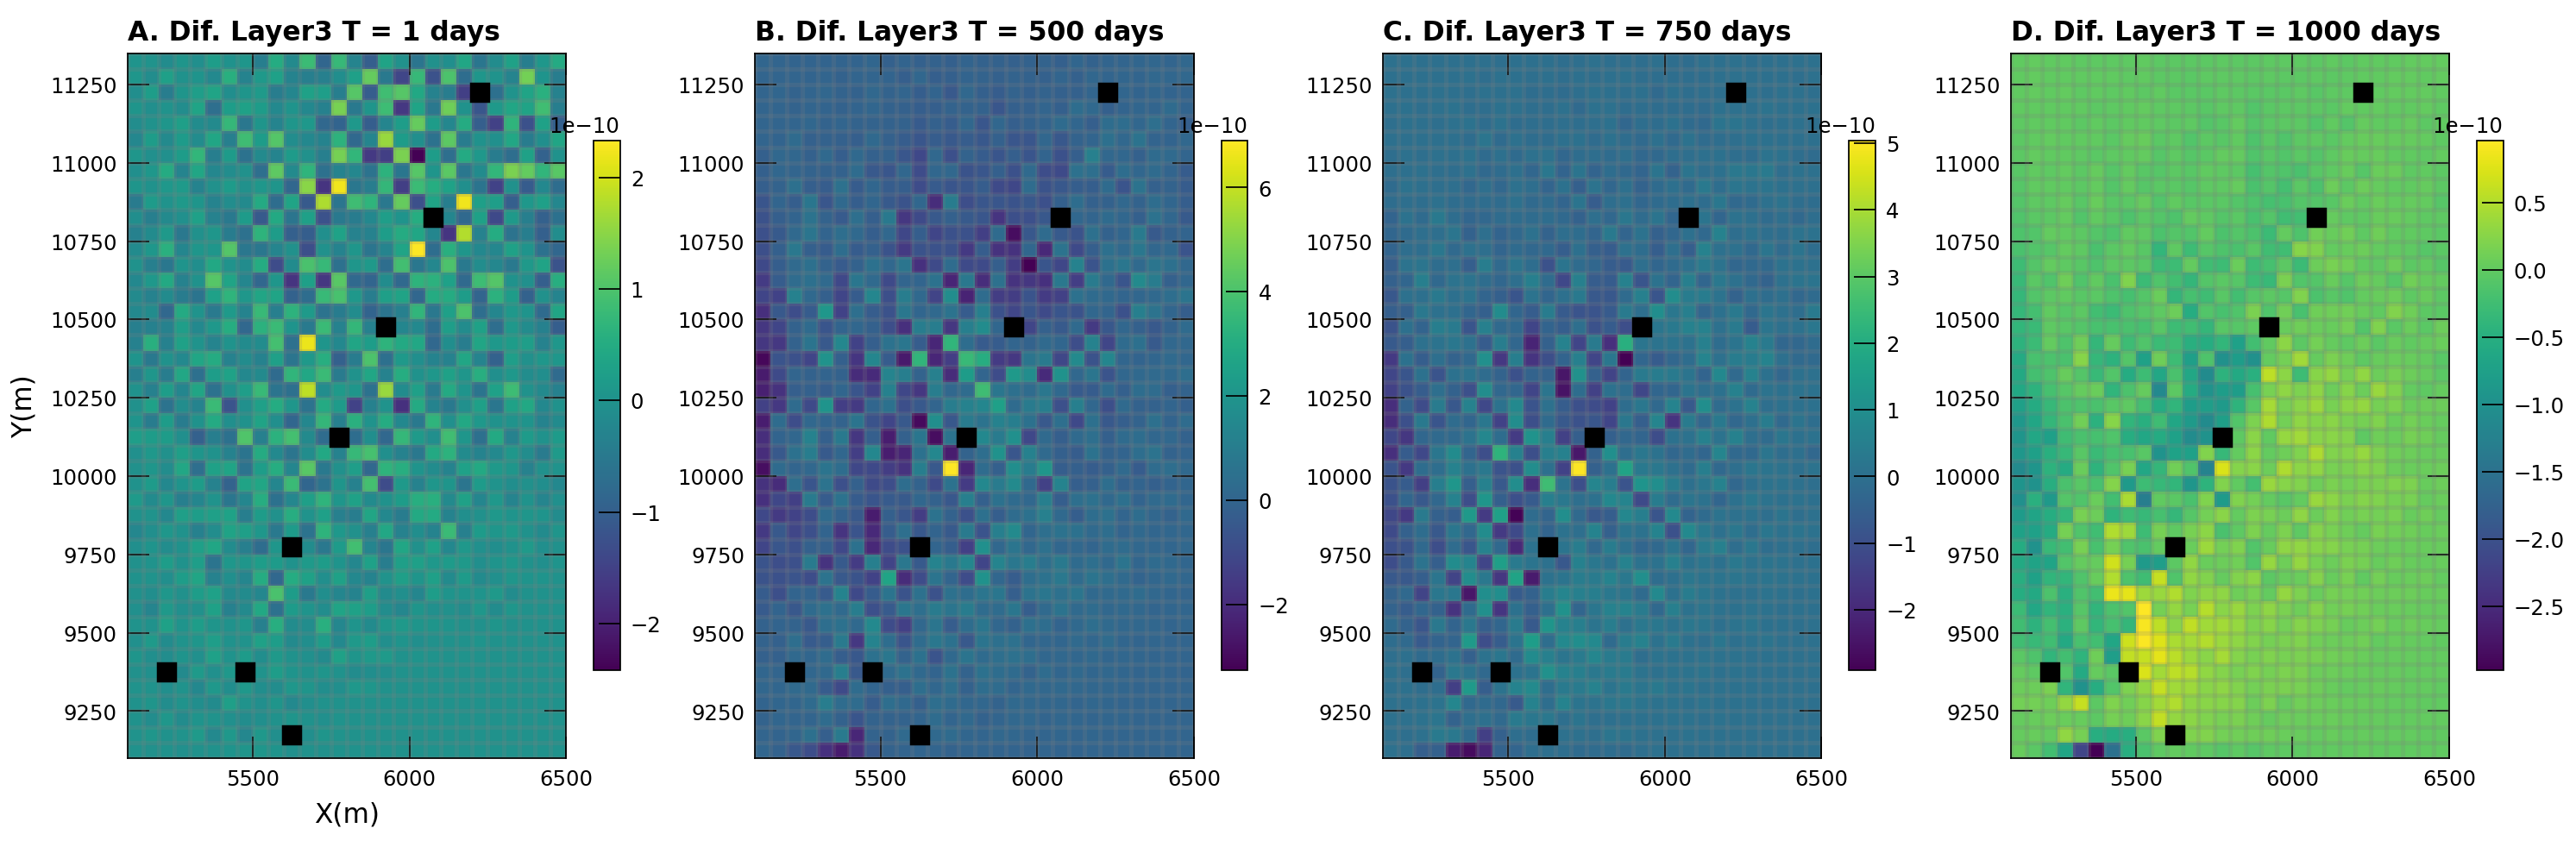

In [37]:
def plot_difference_conc(sim):
    conc_singlemodel_lay3 = get_reference_data_conc()
    gwt_outer = sim.get_model(gwtname_out)         
    gwt       = sim.get_model(gwtname_inn)
    ucnobj_mf6       = gwt.      output.concentration()         ; conc_mf6       = ucnobj_mf6.      get_alldata() 
    ucnobj_mf6_outer = gwt_outer.output.concentration()         ; conc_mf6_outer = ucnobj_mf6_outer.get_alldata()
    with styles.USGSPlot():
        plt.rcParams["lines.dashed_pattern"] = [5.0, 5.0]  ; fig = plt.figure(figsize=(12, 10), dpi=250, tight_layout=True)
        ax=fig.add_subplot(2,4,1,aspect="equal") ;mm=flopy.plot.PlotMapView(model=gwt_outer) ;mm.plot_grid(color=".5", alpha=0.2); istep=0;ilayer=2 #_01 
        c_1day = conc_mf6_outer[istep]  ; c_1day[:, 8:53, 6:34] = conc_mf6[istep]      ; c_1day_singlemodel_lay3 = conc_singlemodel_lay3[istep]
        pa = mm.plot_array(c_1day[ilayer] - c_1day_singlemodel_lay3)                   ; xc, yc = gwt.modelgrid.xycenters
        plt.xlim(5100,5100+28*50)  ; plt.ylim(9100, 9100 + 45 * 50)  ; plt.xlabel("X(m)") ; plt.ylabel("Y(m)") ; plt.colorbar(pa, shrink=0.5)
        for cid, f, c in welspd_mf6:     #  _________________________________________________ well
            plt.plot(xshift + xc[cid[2]], yshift + yc[cid[1]], "ks")
        title = "Dif. Layer3 T = 1 days"  ; styles.heading(letter="A", heading=title)
        ax=fig.add_subplot(2,4,2,aspect="equal") ;mm=flopy.plot.PlotMapView(model=gwt_outer) ;mm.plot_grid(color=".5", alpha=0.2); istep=1;ilayer=2 #_02 
        c_500days = conc_mf6_outer[istep] ; c_500days[:, 8:53, 6:34] = conc_mf6[istep] ; c_500days_singlemodel_lay3 = conc_singlemodel_lay3[istep]
        pa = mm.plot_array(c_500days[ilayer] - c_500days_singlemodel_lay3)             # xc, yc = gwt.modelgrid.xycenters
        plt.xlim(5100,5100+28*50) ; plt.ylim(9100, 9100 + 45 * 50) ; plt.xlabel("") ; plt.ylabel("")  ; plt.colorbar(pa, shrink=0.5)
        for cid, f, c in welspd_mf6:     #  _________________________________________________ well
            plt.plot(xshift + xc[cid[2]], yshift + yc[cid[1]], "ks")
        title = "Dif. Layer3 T = 500 days" ; styles.heading(letter="B", heading=title)  # _________________ Wells
        ax=fig.add_subplot(2,4,3,aspect="equal") ;mm=flopy.plot.PlotMapView(model=gwt_outer) ;mm.plot_grid(color=".5", alpha=0.2); istep=2;ilayer=2 #_03 
        c_750days = conc_mf6_outer[istep] ; c_750days[:, 8:53, 6:34] = conc_mf6[istep] ; c_750days_singlemodel_lay3 = conc_singlemodel_lay3[istep]
        pa = mm.plot_array(c_750days[ilayer] - c_750days_singlemodel_lay3)             # xc, yc = gwt.modelgrid.xycenters
        plt.xlim(5100,5100+28*50)  ; plt.ylim(9100, 9100 + 45 * 50) ; plt.xlabel("")   ; plt.ylabel("") ; plt.colorbar(pa, shrink=0.5)
        for cid, f, c in welspd_mf6:     #  _________________________________________________ well  
            plt.plot(xshift + xc[cid[2]], yshift + yc[cid[1]], "ks")
        title = "Dif. Layer3 T = 750 days" ; styles.heading(letter="C", heading=title)  # _________________ Wells
        ax=fig.add_subplot(2,4,4,aspect="equal") ;mm=flopy.plot.PlotMapView(model=gwt_outer) ;mm.plot_grid(color=".5", alpha=0.2); istep=3;ilayer=2 #_04 
        c_1000days = conc_mf6_outer[istep] ; c_1000days[:, 8:53, 6:34] = conc_mf6[istep] ; c_1000days_singlemodel_lay3 = conc_singlemodel_lay3[istep]
        pa = mm.plot_array(c_1000days[ilayer] - c_1000days_singlemodel_lay3)             # xc, yc = gwt.modelgrid.xycenters
        plt.xlim(5100,5100+28*50) ; plt.ylim(9100, 9100 + 45 * 50)                   ; plt.xlabel("") ; plt.ylabel("") ; plt.colorbar(pa, shrink=0.5)
        for cid, f, c in welspd_mf6:     #  _________________________________________________ well
            plt.plot(xshift + xc[cid[2]], yshift + yc[cid[1]], "ks")
        title = "Dif. Layer3 T = 1000 days" ; styles.heading(letter="D", heading=title) # _________________ Wells
        plt.tight_layout()
def plot_results(sim):
    plot_difference_conc(sim)
def scenario():
    sim = build_models()
    if plot:
        plot_results(sim)
scenario()

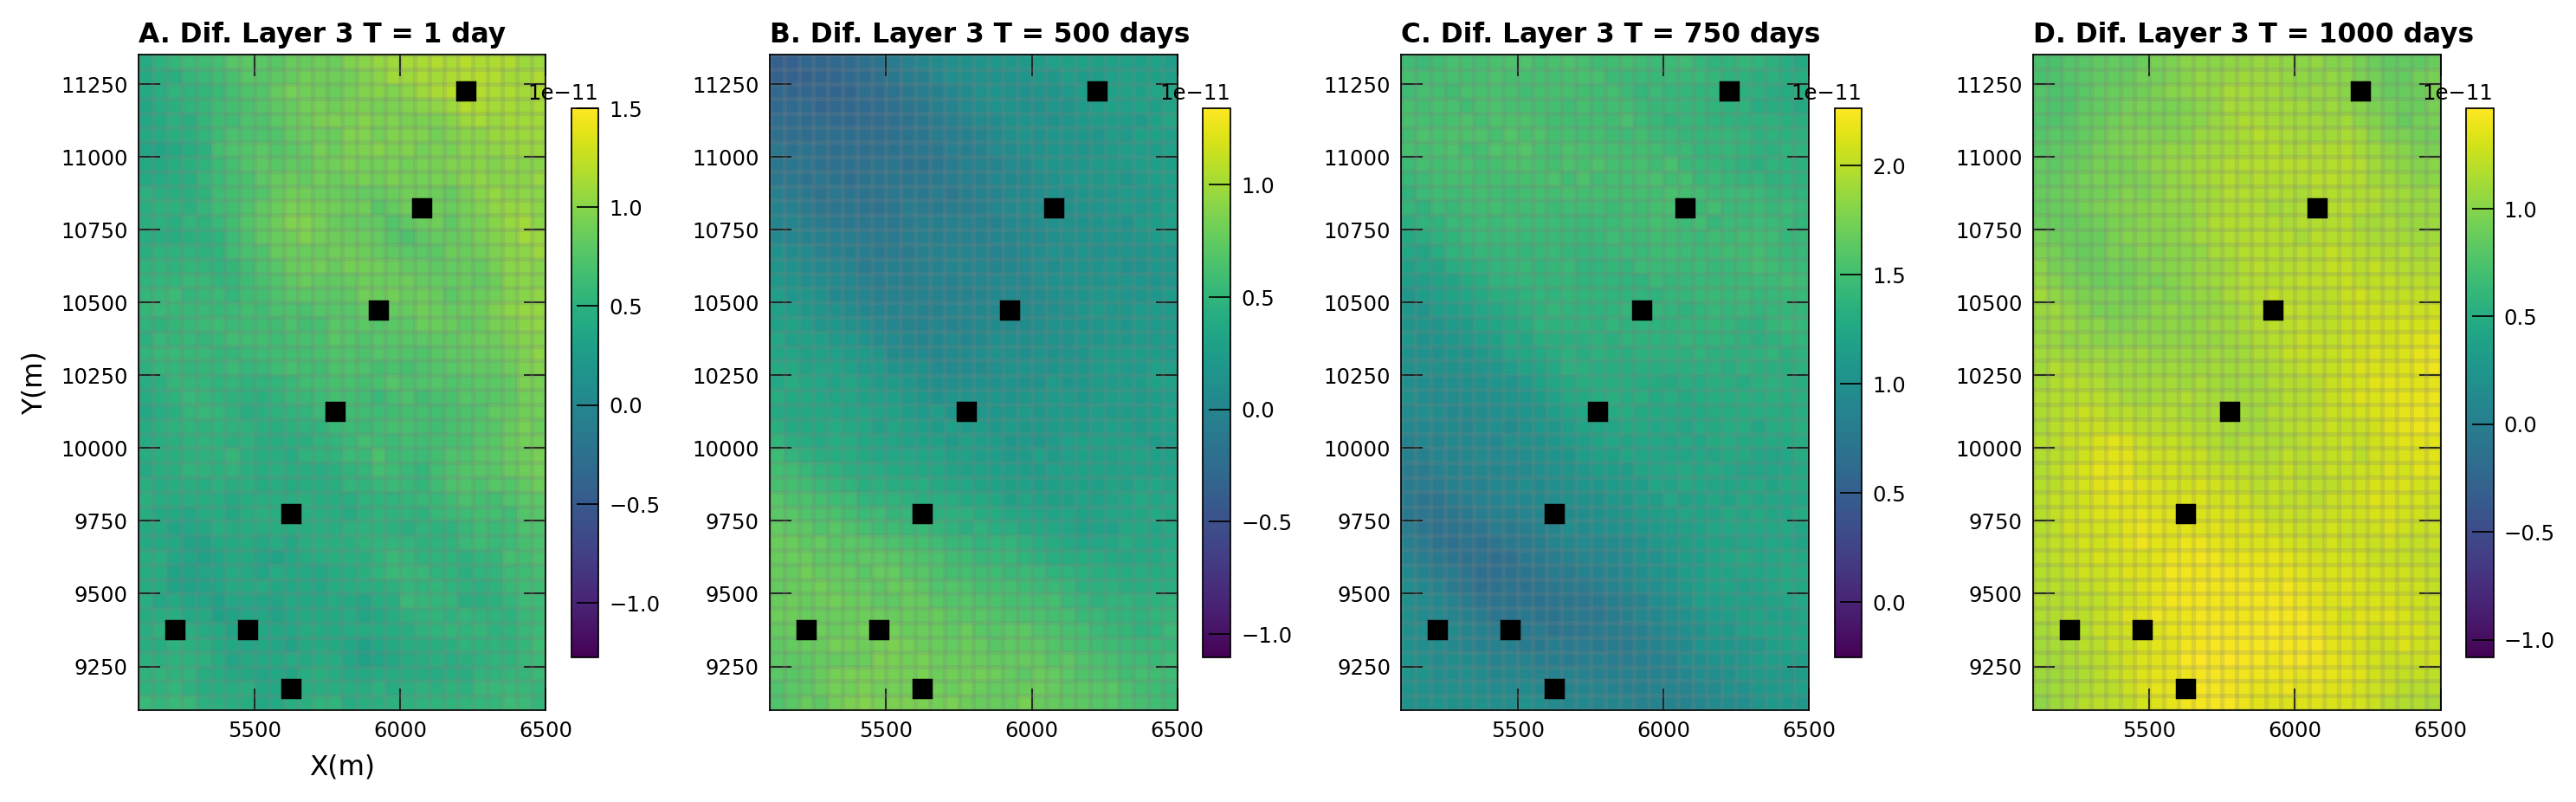

In [42]:
def plot_difference_heads(sim):
    head_singlemodel_lay3 = get_reference_data_heads()        
    gwf_outer   = sim.get_model(gwfname_out)  
    gwf         = sim.get_model(gwfname_inn)
    hobj_mf6       = gwf.      output.head() ;     head_mf6       = hobj_mf6.      get_alldata()  ; 
    hobj_mf6_outer = gwf_outer.output.head() ;     head_mf6_outer = hobj_mf6_outer.get_alldata()
    with styles.USGSPlot():
        plt.rcParams["lines.dashed_pattern"] = [5.0, 5.0] ; fig = plt.figure(figsize=(12, 10), dpi=250, tight_layout=True)
        ax=fig.add_subplot(2,4,1,aspect="equal") ;mm=flopy.plot.PlotMapView(model=gwf_outer) ;mm.plot_grid(color=".5", alpha=0.2); istep=0;ilayer=2 #_01
        h_1day = head_mf6_outer[istep]  ; h_1day[:, 8:53, 6:34] = head_mf6[istep]  ; h_1day_singlemodel_lay3 = head_singlemodel_lay3[istep]         # 1
        pa = mm.plot_array(h_1day[ilayer] - h_1day_singlemodel_lay3)               ; xc, yc = gwf.modelgrid.xycenters   # GRID
        plt.xlim(5100,5100+28*50)  ; plt.ylim(9100, 9100 + 45 * 50) ; plt.xlabel("X(m)")  ; plt.ylabel("Y(m)") ; plt.colorbar(pa, shrink=0.5)
        for cid, f, c in welspd_mf6:     #  _________________________________________________ well
            plt.plot(xshift + xc[cid[2]], yshift + yc[cid[1]], "ks")
        title = "Dif. Layer 3 T = 1 day"       ; styles.heading(letter="A", heading=title)
        ax=fig.add_subplot(2,4,2,aspect="equal") ;mm=flopy.plot.PlotMapView(model=gwf_outer) ;mm.plot_grid(color=".5", alpha=0.2); istep=1;ilayer=2  #_02 
        h_500days = head_mf6_outer[istep] ; h_500days[:, 8:53, 6:34] = head_mf6[istep] ; h_500days_singlemodel_lay3 = head_singlemodel_lay3[istep] # 500
        pa = mm.plot_array(h_500days[ilayer] - h_500days_singlemodel_lay3)
        plt.xlim(5100,5100+28*50) ; plt.ylim(9100, 9100 + 45 * 50) ; plt.xlabel("") ; plt.ylabel("")  ; plt.colorbar(pa, shrink=0.5)
        for cid, f, c in welspd_mf6:     #  _________________________________________________ well
            plt.plot(xshift + xc[cid[2]], yshift + yc[cid[1]], "ks")
        title = "Dif. Layer 3 T = 500 days" ; styles.heading(letter="B", heading=title)
        ax=fig.add_subplot(2,4,3,aspect="equal") ;mm=flopy.plot.PlotMapView(model=gwf_outer) ;mm.plot_grid(color=".5", alpha=0.2); istep=2;ilayer=2 #_03
        h_750days = head_mf6_outer[istep] ; h_750days[:, 8:53, 6:34] = head_mf6[istep] ; h_750days_singlemodel_lay3 = head_singlemodel_lay3[istep] # 750
        pa = mm.plot_array(h_750days[ilayer] - h_750days_singlemodel_lay3)
        plt.xlim(5100,5100+28*50) ; plt.ylim(9100, 9100 + 45 * 50) ; plt.xlabel("") ; plt.ylabel("") ; plt.colorbar(pa, shrink=0.5)
        for cid, f, c in welspd_mf6:     #  _________________________________________________ well
            plt.plot(xshift + xc[cid[2]], yshift + yc[cid[1]], "ks")
        title = "Dif. Layer 3 T = 750 days" ; styles.heading(letter="C", heading=title)
        ax=fig.add_subplot(2,4,4,aspect="equal") ;mm=flopy.plot.PlotMapView(model=gwf_outer) ;mm.plot_grid(color=".5", alpha=0.2); istep=3;ilayer=2 #_04 
        h_1000days=head_mf6_outer[istep] ; h_1000days[:, 8:53, 6:34]=head_mf6[istep]  ; h_1000days_singlemodel_lay3=head_singlemodel_lay3[istep]  # 1000
        pa = mm.plot_array(h_1000days[ilayer] - h_1000days_singlemodel_lay3)
        plt.xlim(5100,5100+28*50) ; plt.ylim(9100, 9100 + 45 * 50) ; plt.xlabel("") ; plt.ylabel("") ; plt.colorbar(pa, shrink=0.5)
        for cid, f, c in welspd_mf6:     #  _________________________________________________ well
            plt.plot(xshift + xc[cid[2]], yshift + yc[cid[1]], "ks")
        title = "Dif. Layer 3 T = 1000 days"
        styles.heading(letter="D", heading=title)
def plot_results(sim):
    plot_difference_heads(sim)
def scenario():
    sim = build_models()
    if plot:
        plot_results(sim)
scenario()

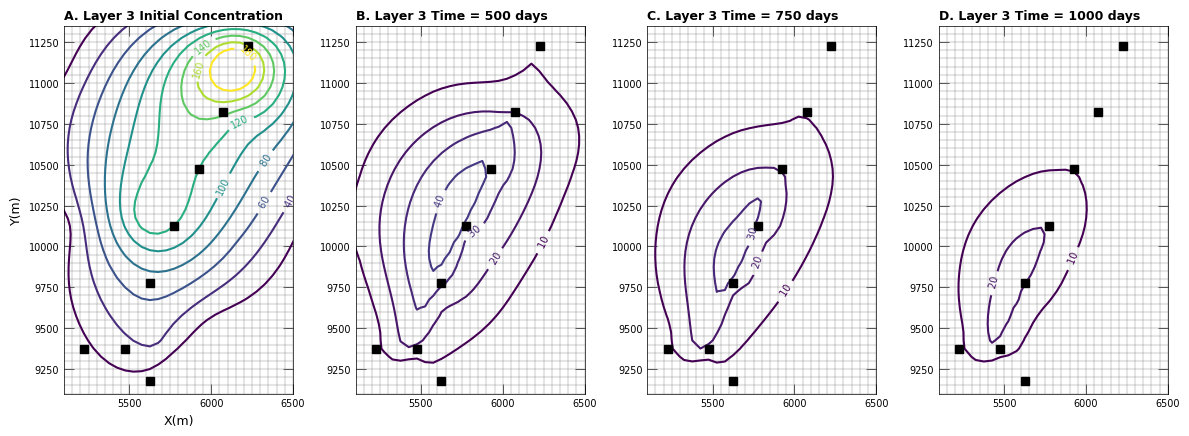

In [43]:
def plot_concentration(sim):
    gwt_outer = sim.get_model(gwtname_out)
    gwt       = sim.get_model(gwtname_inn)
    ucnobj_mf6       = gwt.      output.concentration()       ; conc_mf6       = ucnobj_mf6.      get_alldata()
    ucnobj_mf6_outer = gwt_outer.output.concentration()       ; conc_mf6_outer = ucnobj_mf6_outer.get_alldata()
    with styles.USGSPlot():
        plt.rcParams["lines.dashed_pattern"] = [5.0, 5.0] ; xc, yc = gwt.modelgrid.xycenters ; fig = plt.figure(figsize=(12,10), tight_layout=True)
        ax = fig.add_subplot(2, 4, 1, aspect="equal") ; mm = flopy.plot.PlotMapView(model=gwt_outer) ; mm.plot_grid(color=".5", alpha=0.2)    #_01
        cs = mm.contour_array(sconc[2], levels=np.arange(20, 200, 20))  #  / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / 
        plt.xlim(5100,5100+28*50) ; plt.ylim(9100, 9100 + 45 * 50) ; plt.xlabel("X(m)") ; plt.ylabel("Y(m)") ; plt.clabel(cs, fmt=r"%3d")
        for cid, f, c in welspd_mf6:     #  _________________________________________________ well
            plt.plot(xshift + xc[cid[2]], yshift + yc[cid[1]], "ks")
        title = "Layer 3 Initial Concentration"    ; styles.heading(letter="A", heading=title)
        ax = fig.add_subplot(2, 4, 2, aspect="equal") ; mm = flopy.plot.PlotMapView(model=gwt_outer) ; mm.plot_grid(color=".5", alpha=0.2)    #_02
        c_500days = conc_mf6_outer[1] ; c_500days[:, 8:53, 6:34] = conc_mf6[1]  ; cs = mm.contour_array(c_500days[2], levels=np.arange(10, 200, 10))
        plt.xlim(5100,5100+28*50) ; plt.ylim(9100, 9100 + 45 * 50) ; plt.xlabel("") ; plt.ylabel("") ; plt.clabel(cs, fmt=r"%3d")
        for cid, f, c in welspd_mf6:     #  _________________________________________________ well
            plt.plot(xshift + xc[cid[2]], yshift + yc[cid[1]], "ks")
        title = "Layer 3 Time = 500 days"          ; styles.heading(letter="B", heading=title)
        ax = fig.add_subplot(2, 4, 3, aspect="equal")  ; mm = flopy.plot.PlotMapView(model=gwt_outer)  ; mm.plot_grid(color=".5", alpha=0.2)   #_03
        c_750days = conc_mf6_outer[2] ; c_750days[:, 8:53, 6:34] = conc_mf6[2]  ; cs = mm.contour_array(c_750days[2], levels=np.arange(10, 200, 10))
        plt.xlim(5100,5100+28*50) ; plt.ylim(9100, 9100 + 45 * 50) ; plt.xlabel("") ; plt.ylabel("") ; plt.clabel(cs, fmt=r"%3d")
        for cid, f, c in welspd_mf6:     #  _________________________________________________ well
            plt.plot(xshift + xc[cid[2]], yshift + yc[cid[1]], "ks")
        title = "Layer 3 Time = 750 days" ; styles.heading(letter="C", heading=title)
        ax = fig.add_subplot(2, 4, 4, aspect="equal") ; mm = flopy.plot.PlotMapView(model=gwt_outer) ; mm.plot_grid(color=".5", alpha=0.2)    #_04
        c_1000days = conc_mf6_outer[3] ; c_1000days[:, 8:53, 6:34] = conc_mf6[3] ; cs = mm.contour_array(c_1000days[2], levels=np.arange(10, 200, 10))
        plt.xlim(5100,5100+28*50) ; plt.ylim(9100, 9100 + 45 * 50) ; plt.xlabel("") ; plt.ylabel("") ; plt.clabel(cs, fmt=r"%3d")
        for cid, f, c in welspd_mf6:     #  _________________________________________________ well
            plt.plot(xshift + xc[cid[2]], yshift + yc[cid[1]], "ks")
        title = "Layer 3 Time = 1000 days" ; styles.heading(letter="D", heading=title)
def plot_results(sim):
    plot_concentration(sim)
def scenario():
    sim = build_models()
    if plot:
        plot_results(sim)
scenario()